# Clean the test set
- The test set split we made hasn't been cleaned of mis-labelled samples yet. 
- There is also a set of single species recordings stored in SingleSpecies_all.csv, which contains human verified examples of the target species. 



# Clips will be listened to and labelled with the following confidence categories:

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is definitely correct
- 4 FOCAL means the present label is correct and the target species vocalization is prominent
- 5 Label needs changing from absent to present 
- 6 Label needs changing from present to absent

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
from src.utils import verify_samples, plot_locations, show_samples_in_df, show_sample_from_df
from src.data import build


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the test set
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
test_ds = test_df[["target_present"]]
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

# A csv file contianing human verified single species tags was provided. 
The positive samples from this test set can be appended to the test set we constructed to provide another source of target vocalizations.

In [4]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
# filter out all the other species
osfls = ext_df.loc[ext_df.species_code == "OSFL"]
# filter out the target species calls and keep the songs. 
osfls = osfls.loc[osfls.vocalization == "Song"]
osfls["target_present"] = 1.0

Download the recordings referenced in the external test set which are not yet saved to disk

The file download function requires a couple of extra columns besides the recording URL: the filename and file extension. 

In [5]:
osfls.columns

Index(['organization', 'project_id', 'location', 'location_id',
       'location_buffer_m', 'longitude', 'latitude', 'equipment_make',
       'equipment_model', 'recording_id', 'recording_date_time', 'task_id',
       'aru_task_status', 'task_duration', 'task_method', 'species_code',
       'species_common_name', 'species_scientific_name', 'individual_order',
       'tag_id', 'individual_count', 'vocalization', 'detection_time',
       'tag_duration', 'rms_peak_dbfs', 'tag_is_verified', 'tag_rating',
       'observer', 'observer_id', 'species_individual_comments',
       'task_comments', 'wildtrax_url', 'recording_url', 'target',
       'target_present'],
      dtype='object')

# Download long recordings not already saved on disk 

In [6]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    
    return f"recording-{df.recording_id}.{df.file_type}"

osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)

In [7]:
build.download_recordings.from_url(osfls,'recording_url', recording_save_path)

downloading 39 clips
skipped 39 previously downloaded files


make a dataframe of 3 second clips containing the target audio

In [8]:
osfls.head()

,organization,project_id,location,location_id,location_buffer_m,longitude,latitude,equipment_make,equipment_model,recording_id,...,observer,observer_id,species_individual_comments,task_comments,wildtrax_url,recording_url,target,target_present,file_type,filename
9789,BU,787,OSFL-AB-10-1,98510,NaN,-111.496876,57.443536,NaN,NaN,255472,...,Erin Bayne,17,NaN,NaN,https://www.wildtrax.ca/home/aru-tasks/recordi...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,OSFL,1.0,flac,recording-255472.flac
9798,BU,787,OSFL-AB-1-1,98531,NaN,-111.418890,57.523776,NaN,NaN,255412,...,Erin Bayne,17,NaN,NaN,https://www.wildtrax.ca/home/aru-tasks/recordi...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,OSFL,1.0,mp3,recording-255412.mp3
9824,BU,787,OSFL-AB-14-1,98505,NaN,-111.405270,57.522751,NaN,NaN,255913,...,Erin Bayne,17,NaN,NaN,https://www.wildtrax.ca/home/aru-tasks/recordi...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,OSFL,1.0,flac,recording-255913.flac
9825,BU,787,OSFL-AB-14-1,98505,NaN,-111.405270,57.522751,NaN,NaN,255913,...,Erin Bayne,17,NaN,NaN,https://www.wildtrax.ca/home/aru-tasks/recordi...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,OSFL,1.0,flac,recording-255913.flac
9826,BU,787,OSFL-AB-14-1,98505,NaN,-111.405270,57.522751,NaN,NaN,255913,...,Erin Bayne,17,NaN,NaN,https://www.wildtrax.ca/home/aru-tasks/recordi...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,OSFL,1.0,flac,recording-255913.flac


In [9]:
osfls['end_time'] = osfls['detection_time'] + 3
osfls['path'] = "../../data/raw/recordings/OSFL/" + osfls['filename']
osfls['file'] = osfls['path'].apply(lambda x: Path(x))
osfls['source'] = "SingleSpecies_all.csv"

osfls.columns

Index(['organization', 'project_id', 'location', 'location_id',
       'location_buffer_m', 'longitude', 'latitude', 'equipment_make',
       'equipment_model', 'recording_id', 'recording_date_time', 'task_id',
       'aru_task_status', 'task_duration', 'task_method', 'species_code',
       'species_common_name', 'species_scientific_name', 'individual_order',
       'tag_id', 'individual_count', 'vocalization', 'detection_time',
       'tag_duration', 'rms_peak_dbfs', 'tag_is_verified', 'tag_rating',
       'observer', 'observer_id', 'species_individual_comments',
       'task_comments', 'wildtrax_url', 'recording_url', 'target',
       'target_present', 'file_type', 'filename', 'end_time', 'path', 'file',
       'source'],
      dtype='object')

In [10]:
model = opso.load_model(model_save_path/"OSFL.model")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

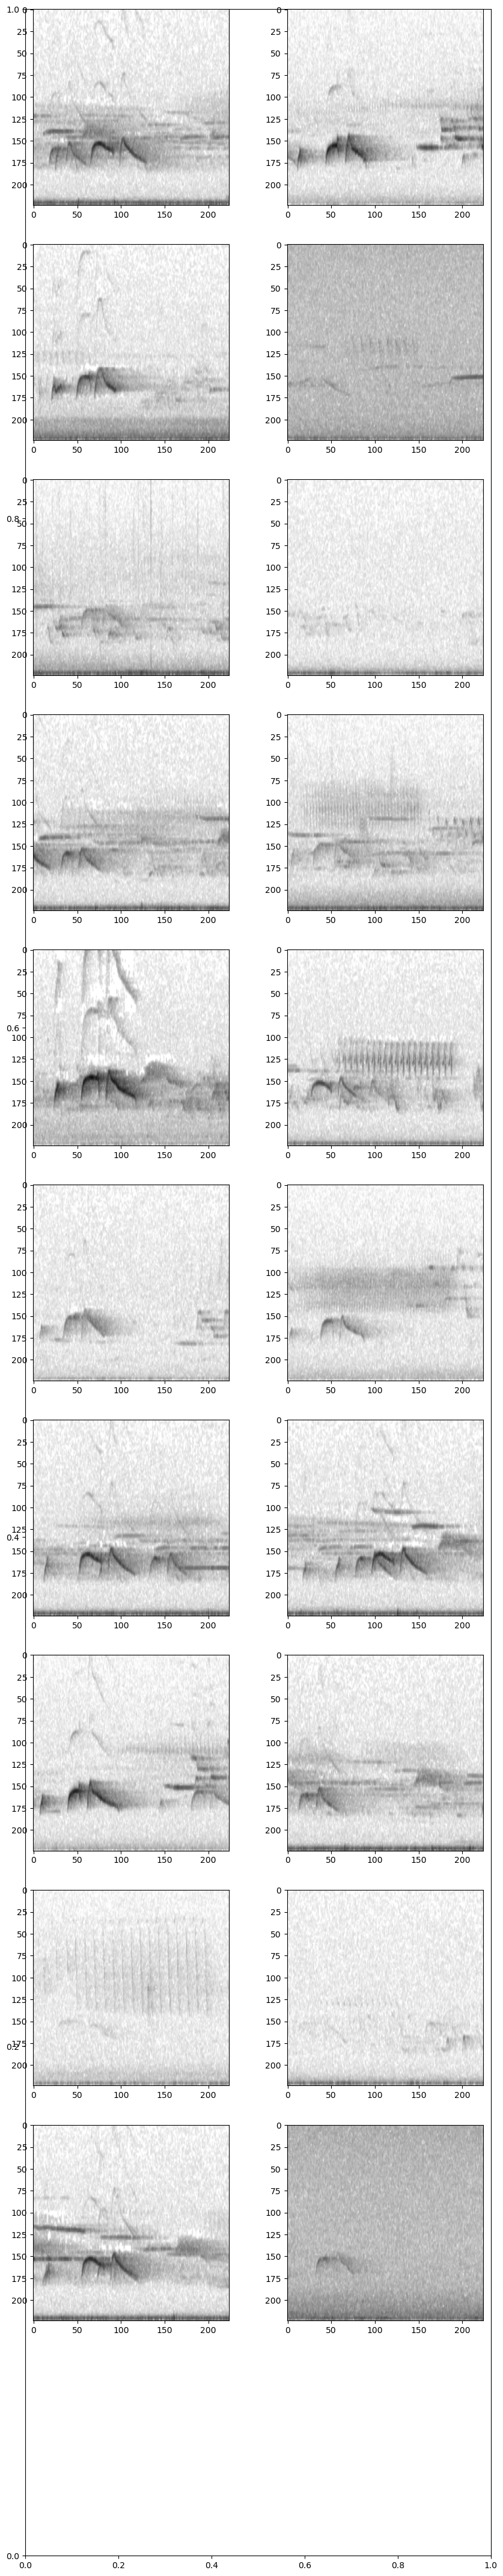

In [11]:
external_test_set_osfls_df = osfls.set_index(['file', 'detection_time', 'end_time'])
external_test_set_osfls_df.index.names = ['file', 'start_time', 'end_time']
show_samples_in_df(external_test_set_osfls_df.sample(20), model)

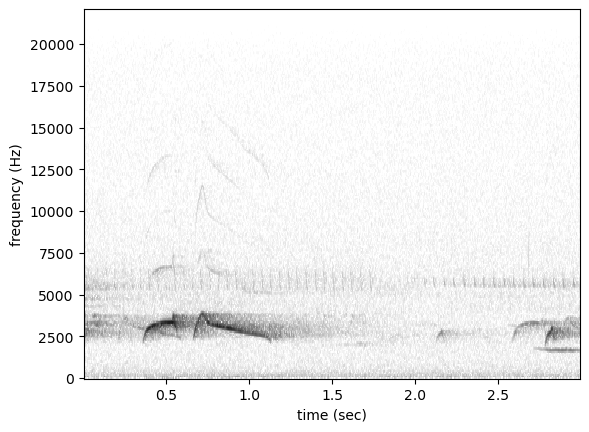

In [12]:
show_sample_from_df(external_test_set_osfls_df)

# Check the locations of the test set


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


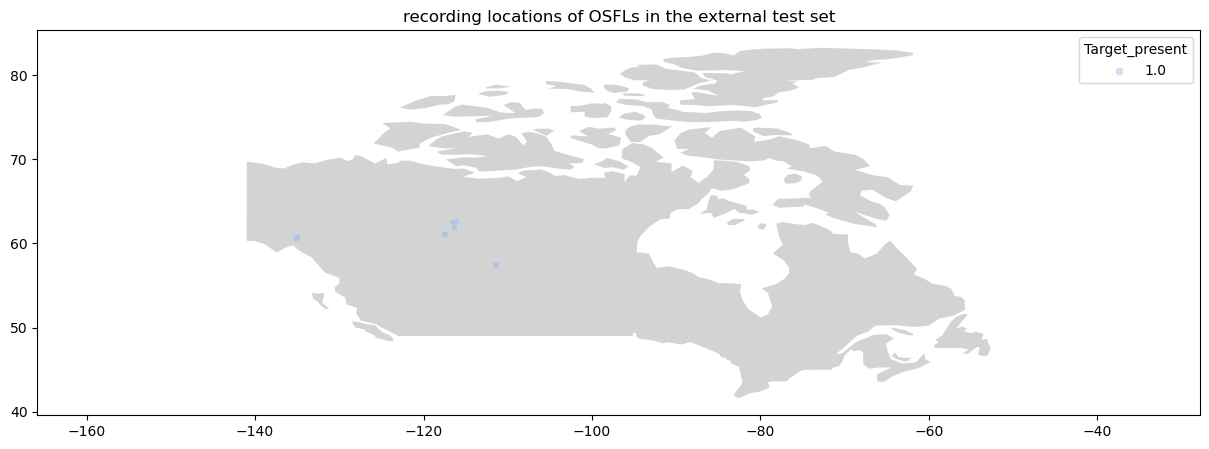

In [13]:
plot_locations(osfls.loc[osfls.target_present==1], feature='target_present', title='recording locations of OSFLs in the external test set')

It looks as though the spread of locations in the test set isn't very wide - there are four tight clusters of locations. Therefore this test set can not be used as an indicator of model performance across a wide set of locations. 

# Process the withheld test set created during train/valid/split in the same way that the validation set was processed

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


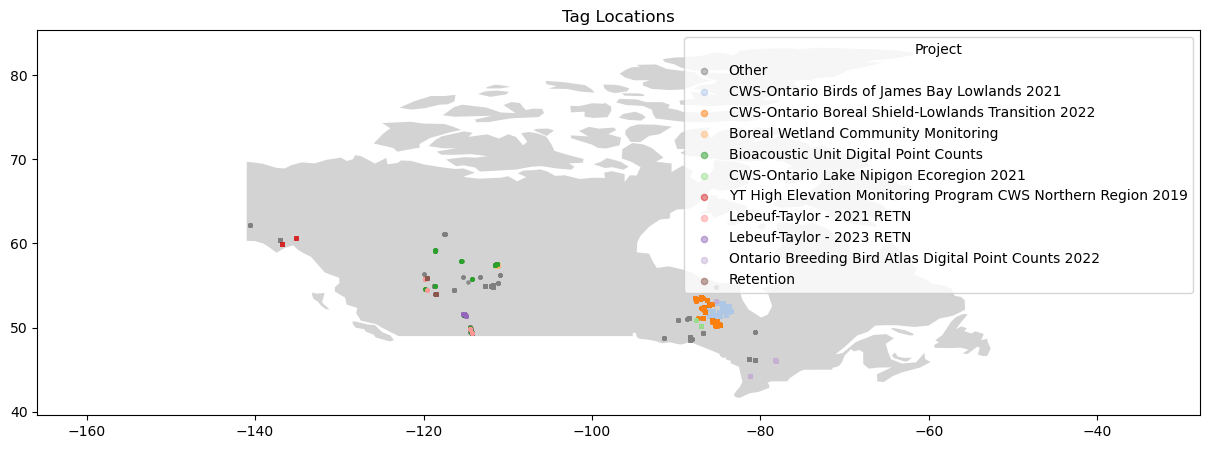

In [15]:
plot_locations(test_df)

The withheld test dataset we split off at the start of the project contains a wider spread of audio sources.

In [16]:
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

# Verify the samples in the test set

#### * Skip this section if validation has already begun.

In [165]:
model = opso.cnn.load_model(model_save_path / "OSFL.model")
predictions = model.predict(test_ds, batch_size=64, activation_layer="sigmoid")

  0%|          | 0/182 [00:00<?, ?it/s]

In [38]:
predictions.rename(columns={"target_present": "predicted"}, inplace=True)

In [39]:
test_df = pd.concat([test_df, predictions], axis=1)

In [40]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])

test_df["loss"] = calculate_loss(test_df)


# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in test_df.columns:
    test_df['confidence_cat'] = 0

# * If cleaning has already begun, load the cleaned data here instead
This will load any previously entered confidence category work. 

In [22]:
if Path.exists(data_path / "interim" / "test_set" / "test_set_verified.pkl"):
    test_df_verified = pd.read_pickle(data_path / "interim" / "test_set" / "test_set_verified.pkl")
else:
    test_df_verified = test_df

In [329]:
test_df_verified = verify_samples(test_df_verified, ground_truth=1.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


To cycle through the samples, hit ctrl+enter to execute the current code cell and keep it focussed. 

<Axes: xlabel='confidence_cat'>

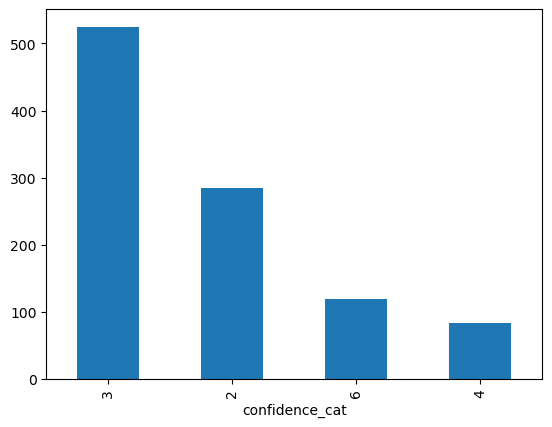

In [330]:
counts = test_df_verified.loc[test_df_verified.target_present==1.0].confidence_cat.value_counts()
# plot the counts and re-label the x labels with the confidence categories
counts.plot(kind='bar')

- __cat 3__ is confirmed OSFL
- __cat 4__ is focal example
- __cat 6__ is target absent
- __cat 2__ was difficult to descern one way or another. 

The obvious mis-labels should be re-labelled.


After verifying the present samples in the test set, we are left with just under 600 present samples.


# Verify the absent class
The absent class is much larger than the present class, so we'll use a different strategy to clean these samples:
- Go through the samples which are labelled as absent with the highest loss, and re-label those where the target is actually present. 
- Take a sample of the items in the shuffled validation set equal to the number of present samples available. Verify all of these. 
- This will give us a fully checked training set with equal numbers of samples from each class.
- Additionally we'll have gone through the top section of samples in the validation set which are most likely to have been mis-labelled. 

### Note that there is a danger of biasing the contents of the test dataset during this process. 
To help mitigate this, the uncertain samples labelled cat 2 are kept, and can either be dropped or included in the test data.

target = 0.0, prediction = 0.8399062156677246 loss = 0.8399062156677246


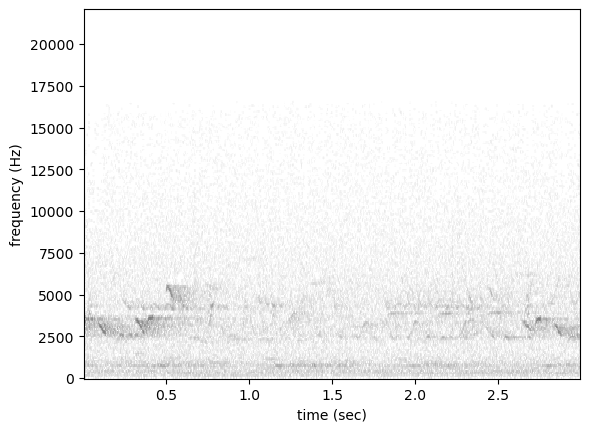

added confidence tag 3 to the dataframe.
confidence_cat
0    8227
3     238
5      69
2      36
1       1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [1120]:
test_df_verified = verify_samples(test_df_verified, ground_truth=0.0, loss_sorted=True)

In [173]:
# plot the counts of verification work on the absent class. 
test_df_verified.loc[test_df_verified.target_present==0.0].confidence_cat.value_counts()

confidence_cat
0    10474
5       63
3       36
2       23
Name: count, dtype: int64

# Build a balanced test set


In [331]:
test_df_verified.loc[test_df_verified.target_present == 1.0].confidence_cat.value_counts()

confidence_cat
3    525
2    284
6    119
4     83
Name: count, dtype: int64

In [337]:
# Add a source column so that we can see where the data came from. 
test_df["source"] = "withheld-test-set"
test_df_verified["source"] = "withheld-test-set"

In [347]:
# Build a balanced test set
n_samples_per_class = 500

# Choose all of the focal present samples
focal_present = test_df_verified.loc[test_df_verified.target_present==1.0].loc[test_df_verified.confidence_cat==4]

# Load the validation set of absent samples from locations outside of the target species' habitat
other_habitats_absent = pd.read_pickle(data_path / "interim" / "test_set" / "other_habitat_test.pkl")
other_habitats_absent["source"] = "other-habitats-absent"

# Choose a random sample of the remaining present samples
present = test_df_verified.loc[test_df_verified.target_present==1.0].loc[test_df_verified.confidence_cat==3]
present = pd.concat([focal_present, present.sample(n=n_samples_per_class-len(focal_present))])
print(len(present))

# Choose a random sample of 600 absent samples to verify - knowing that we'll want to end up with 500 and some will be mis-labelled.
absent = test_df_verified.loc[test_df_verified.target_present==0.0].sample(n=n_samples_per_class + 100)

500


In [1975]:
absent = verify_samples(absent, ground_truth=0.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


# Construct a balanced validation set from equal numbers of verified samples. 

In [360]:
absent = absent.loc[absent.confidence_cat==3].sample(n=n_samples_per_class, random_state=42)
balanced_test_df = pd.concat([present, absent, external_test_set_osfls_df.sample(300), other_habitats_absent.sample(300)])

balanced_test_df.target_present.value_counts()

target_present
1.0    800
0.0    800
Name: count, dtype: int64

In [361]:
balanced_test_df.source.value_counts()

source
withheld-test-set        500
SingleSpecies_all.csv    300
other-habitats-absent    300
Name: count, dtype: int64

# Save the verification work to disk

In [363]:
test_df_verified.to_pickle(data_path / "interim" / "test_set" / "test_set_verified.pkl")
balanced_test_df.to_pickle(data_path / "interim" / "test_set" / "balanced_test_set_verified.pkl")

In [364]:
test_df_verified.confidence_cat.value_counts()

confidence_cat
0    10474
3      561
2      307
6      119
4       83
5       63
Name: count, dtype: int64

In [365]:
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

# Concluding notes
We started out with a data set which relied entirely on human labels from wildtrax. Some of these contained errors, so we went through and manually checked all of the 1011  present samples, and did some top-down cleaning of the larger absent samples in order to find obvious mis-labels. 

Then a random sample of 500 was taken from each class, and any which hadn't yet been verified were checked again. 


1. A set of 500 verified present samples and 500 verified absent samples is saved as __balanced_test_set_verified__

2. A larger set of 10596 absent samples and 1011 present samples is available too. The present samples were all checked, and the absent samples were sorted by highest error between prediction and label (loss), then the top few hundred of these were checked, until the model predictions were below 80% and there were relatively few actual present samples. A confidence category is assigned to these so that they can be re-labelled. This dataset is saved as __test_set_verified__


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


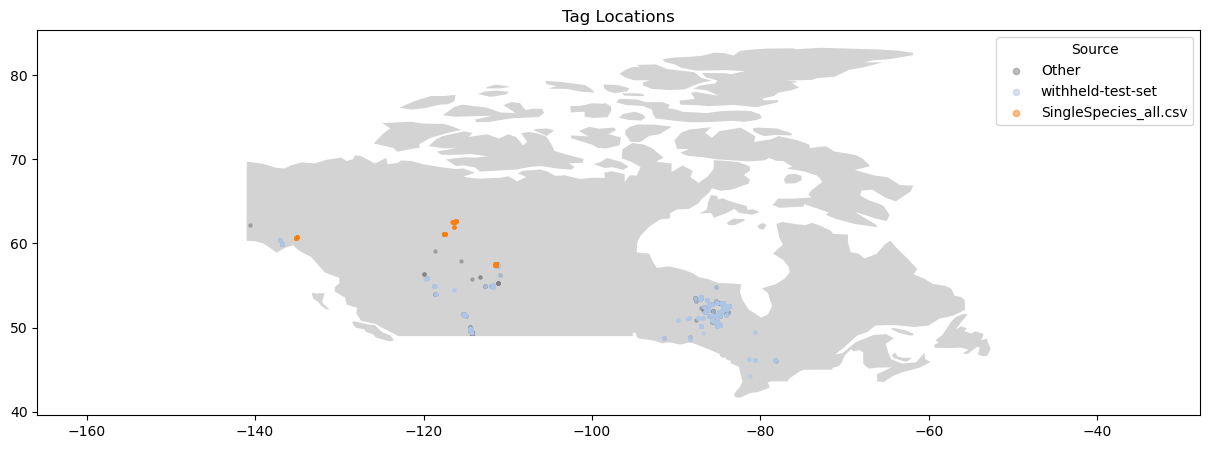

In [368]:
plot_locations(balanced_test_df, feature='source')

The locations in the test set seem representative of the available dataset as a whole. 

In [370]:
from utils import clean_confidence_cats
clean_confidence_cats(test_df_verified)
print("number of samples per class in the training set after cleaning")
test_df_verified.target_present.value_counts(), balanced_test_df.target_present.value_counts()

number of samples per class in the training set after cleaning


(target_present
 0.0    10652
 1.0      955
 Name: count, dtype: int64,
 target_present
 1.0    800
 0.0    800
 Name: count, dtype: int64)

# Notes on the test sets
- Testing the model against a balanced test set with equal numbers of samples per class is one way to calculate the metrics which will keep the accuracy metric meaningful, and it also allows checking of every sample in the dataset by hand.
- Testing the model against the larger test set with thousands of absent samples will  will give a better feel for how the model will perform in production - since there is likely to be much more absent audio than present audio at inference time - these are unlikely to occur at a 50/50 ratio in any case.
- Mixing in audio from outside the habitat of the target species will give an indicator of how other "sound-alike" species from outside the target species habitat will show up as false positives. 
- Mixing in audio from the provided test set provides another externally verified source of target species vocalizations. 